# 0. Setting
<hr>

In [1]:
# import library
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import math
from pandas import Series, DataFrame
import pandas as pd
import numpy as np

torch.__version__


'1.7.0+cu101'

# 1. Data
<hr>

In [44]:
from torchvision import transforms, datasets

data_path = './MNIST'

data_train  = datasets.MNIST(root = data_path, train= False, download=True)
data_test = datasets.MNIST(root = data_path, train= True, download=True)

data_train_mean = data_train.data.float().mean()/255
data_train_std = data_train.data.float().std()/255

data_test_mean = data_test.data.float().mean()/255
data_test_std = data_test.data.float().std()/255


print("train data mean = {}, std = {}".format(data_train_mean, data_train_std))
print("test data mean = {}, std = {}".format(data_test_mean, data_test_std))

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,)),  # mean value = 0.1307, standard deviation value = 0.3081
])

'''
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_train_mean,),(data_train_std,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((data_test_mean,),(data_test_std,)),
])
'''

data_train  = datasets.MNIST(root = data_path, train= False, download=True, transform= transform)
data_test   = datasets.MNIST(root = data_path, train= True, download=True, transform= transform)

print("the number of your training data (must be 10,000) = ", data_train.__len__())
print("hte number of your testing data (must be 60,000) = ", data_test.__len__())


train data mean = 0.1325146108865738, std = 0.3104802668094635
test data mean = 0.13066047430038452, std = 0.30810779333114624
the number of your training data (must be 10,000) =  10000
hte number of your testing data (must be 60,000) =  60000


# 2.Model
<hr>

In [59]:
def init_weights_xaiver(m):
  if type(m) == nn.Linear:
    nn.init.xavier_normal_(m.weight.data)
    m.bias.data.fill_(0)

def init_weights_he(m):
  if type(m) == nn.Linear:
    nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
    m.bias.data.fill_(0)

class classification(nn.Module):

    def __init__(self):
        super(classification, self).__init__()
        
        # construct layers for a neural network
        self.classifier1 = nn.Sequential(
            nn.Linear(in_features=28*28, out_features=20*20),
            nn.ReLU(),
            #nn.Sigmoid(),
            #nn.Tanh()
            #nn.LeakyReLU(),
            nn.Dropout(0.15)
        ) 
        self.classifier2 = nn.Sequential(
            nn.Linear(in_features=20*20, out_features=10*10),
            nn.ReLU(),
            #nn.Sigmoid()
            #nn.Tanh()
            #nn.LeakyReLU(),
            nn.Dropout(0.15)
        ) 
        self.classifier3 = nn.Sequential(
            nn.Linear(in_features=10*10, out_features=10),
            nn.LogSoftmax(dim=1)
        ) 

        self.classifier1.apply(init_weights_he)
        self.classifier2.apply(init_weights_he)
        self.classifier3.apply(init_weights_he)
        
    def forward(self, inputs):                 # [batchSize, 1, 28, 28]
        x = inputs.view(inputs.size(0), -1)    # [batchSize, 28*28]
        x = self.classifier1(x)                # [batchSize, 20*20]
        x = self.classifier2(x)                # [batchSize, 10*10]
        out = self.classifier3(x)              # [batchSize, 10]
        
        return out


# 3. Loss Function
<hr>

In [4]:
model = classification()
criterion = nn.CrossEntropyLoss()
train_y_pred = model(data_train.data.float())
train_y = data_train.targets
temp_loss = criterion(train_y_pred, train_y)
print(temp_loss.data.item())

2.3054168224334717


#4. Optimization
<hr>

Define Train Function

In [5]:
def train(model, criterion, train_loader, optimizer, batch_size):
  
  model.train()
  loss_sum = 0
  acc_sum = 0
  iteration = 0
  for xs, ts in iter(train_loader):

    iteration = iteration + 1
    optimizer.zero_grad()
    y_pred = model(xs)
    loss = criterion(y_pred, ts)
    loss.backward()
    optimizer.step()
    
    loss_sum = loss_sum + float(loss)
    zs = y_pred.max(1, keepdim=True)[1] # first column has actual prob
    acc_sum = acc_sum + zs.eq(ts.view_as(zs)).sum().item()/batch_size
  
  loss_avg = math.trunc(loss_sum/iteration * 100) / 100
  acc_avg = math.trunc(acc_sum/iteration * 100) / 100
  
  return loss_avg, acc_avg

Define Test Function

In [6]:
def test(model,criterion, test_loader, batch_size):
  model.eval()
  loss_sum = 0
  acc_sum = 0
  iteration = 0
  with torch.no_grad():
    for xs, ts in iter(test_loader):
      iteration = iteration + 1
      y_pred = model(xs)
      loss_sum = loss_sum + criterion(y_pred, ts).data.item()
      zs = y_pred.max(1, keepdim=True)[1]
      acc_sum = acc_sum + zs.eq(ts.view_as(zs)).sum().item()/batch_size
  
  loss_avg = math.trunc(loss_sum/iteration * 100) / 100
  acc_avg = math.trunc(acc_sum/iteration * 100) / 100
  
  return loss_avg, acc_avg

Define Gradient Descent Fucntion

In [7]:
def gradient_descent(model, optimizer, criterion, batch_size, num_epochs):

  # batching
  train_loader = torch.utils.data.DataLoader(
      data_train,
      batch_size=batch_size,
      num_workers=2,
      shuffle=True,
      drop_last=True)
  
  test_loader = torch.utils.data.DataLoader(
      data_test,
      batch_size=batch_size,
      num_workers=2,
      shuffle=False,
      drop_last=True)
  
  
  # return variables
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  
  # run training & testing
  for epoch in range(num_epochs + 1):

    train_loss_avg, train_acc_avg = train(model, criterion, train_loader, optimizer, batch_size)
    test_loss_avg, test_acc_avg = test(model, criterion, test_loader, batch_size)
    
    # add loss and accuracy data
    train_loss_list.append(train_loss_avg)
    train_acc_list.append(train_acc_avg)
    test_loss_list.append(test_loss_avg)
    test_acc_list.append(test_acc_avg)

    # print
    if epoch % 10 != 0 :
      continue

    print("epoch : ", epoch, " -------------------------------------- ")
    print("train loss : {}      accuracy = {}".format(train_loss_avg, train_acc_avg))
    print("test loss : {}       accuracy = {}".format(test_loss_avg, test_acc_avg))


  return train_loss_list, train_acc_list, test_loss_list, test_acc_list


# 5. Select Hyperparameter & Modify/Test Model
<hr>

size of the mini-batch : 64
<br>optimization algorithm : SGD
<br>loss funtion : cross entropy
<br>regularization algorithm : -
<br>learning rate : constant

In [ ]:
# model
model = classification()

# mini-batch size
batch_size = 32

# num of epochs
num_epochs = 200

# learning rate
learning_rate = 0.01

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)

# loss function
criterion = nn.CrossEntropyLoss()

# run
train_loss_list1, train_acc_list1, test_loss_list1, test_acc_list1 = gradient_descent(model, optimizer, criterion, batch_size, num_epochs)

epoch :  0  -------------------------------------- 
train loss : 2.302      accuracy = 0.146
test loss : 2.288       accuracy = 0.136
epoch :  10  -------------------------------------- 
train loss : 2.023      accuracy = 0.761
test loss : 2.018       accuracy = 0.753
epoch :  20  -------------------------------------- 
train loss : 1.843      accuracy = 0.821
test loss : 1.846       accuracy = 0.808
epoch :  30  -------------------------------------- 
train loss : 1.761      accuracy = 0.845
test loss : 1.769       accuracy = 0.828
epoch :  40  -------------------------------------- 
train loss : 1.713      accuracy = 0.86
test loss : 1.722       accuracy = 0.845
epoch :  50  -------------------------------------- 
train loss : 1.681      accuracy = 0.872
test loss : 1.691       accuracy = 0.858
epoch :  60  -------------------------------------- 
train loss : 1.657      accuracy = 0.882
test loss : 1.669       accuracy = 0.866
epoch :  70  -------------------------------------- 
trai

In [8]:
def gradient_descent_with_scheduler(scheduler, model, optimizer, criterion, batch_size, num_epochs):

  # batching
  train_loader = torch.utils.data.DataLoader(
      data_train,
      batch_size=batch_size,
      num_workers=2,
      shuffle=True,
      drop_last=True)
  
  test_loader = torch.utils.data.DataLoader(
      data_test,
      batch_size=batch_size,
      num_workers=2,
      shuffle=False,
      drop_last=True)
  
  
  # return variables
  train_loss_list, train_acc_list = [], []
  test_loss_list, test_acc_list = [], []

  
  # run training & testing
  for epoch in range(num_epochs + 1):

    train_loss_avg, train_acc_avg = train(model, criterion, train_loader, optimizer, batch_size)
    test_loss_avg, test_acc_avg = test(model, criterion, test_loader, batch_size)
    scheduler.step(train_loss_avg)
        
    # add loss and accuracy data
    train_loss_list.append(train_loss_avg)
    train_acc_list.append(train_acc_avg)
    test_loss_list.append(test_loss_avg)
    test_acc_list.append(test_acc_avg)

    # print
    if epoch % 10 != 0 :
      continue

    print("epoch : ", epoch, " -------------------------------------- ")
    print("train loss : {}      accuracy = {}".format(train_loss_avg, train_acc_avg))
    print("test loss : {}       accuracy = {}".format(test_loss_avg, test_acc_avg))


  return train_loss_list, train_acc_list, test_loss_list, test_acc_list


In [61]:
# model
model = classification()

# mini-batch size
batch_size = 32

# num of epochs
num_epochs = 100

# learning rate
learning_rate = 0.01

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.3, verbose=True)   

# loss function
criterion = nn.CrossEntropyLoss()

# run
train_loss_list8, train_acc_list8, test_loss_list8, test_acc_list8 = gradient_descent_with_scheduler(scheduler, model, optimizer, criterion, batch_size, num_epochs)

epoch :  0  -------------------------------------- 
train loss : 0.85      accuracy = 0.72
test loss : 0.42       accuracy = 0.88
epoch :  10  -------------------------------------- 
train loss : 0.13      accuracy = 0.95
test loss : 0.2       accuracy = 0.94
epoch :  20  -------------------------------------- 
train loss : 0.06      accuracy = 0.97
test loss : 0.18       accuracy = 0.95
epoch :  30  -------------------------------------- 
train loss : 0.03      accuracy = 0.98
test loss : 0.17       accuracy = 0.95
epoch :  40  -------------------------------------- 
train loss : 0.03      accuracy = 0.99
test loss : 0.17       accuracy = 0.95
Epoch    51: reducing learning rate of group 0 to 3.0000e-03.
epoch :  50  -------------------------------------- 
train loss : 0.02      accuracy = 0.99
test loss : 0.17       accuracy = 0.95
epoch :  60  -------------------------------------- 
train loss : 0.01      accuracy = 0.99
test loss : 0.18       accuracy = 0.95
Epoch    63: reducing l

In [27]:
# model
model = classification()

# mini-batch size
batch_size = 64

# num of epochs
num_epochs = 100

# learning rate
learning_rate = 0.01

# optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience = 5, verbose=True)   

# loss function
criterion = nn.CrossEntropyLoss()

# run
train_loss_list7, train_acc_list7, test_loss_list7, test_acc_list7 = gradient_descent_with_scheduler(scheduler, model, optimizer, criterion, batch_size, num_epochs)

epoch :  0  -------------------------------------- 
train loss : 1.84      accuracy = 0.36
test loss : 1.25       accuracy = 0.62
epoch :  10  -------------------------------------- 
train loss : 0.24      accuracy = 0.92
test loss : 0.25       accuracy = 0.93
epoch :  20  -------------------------------------- 
train loss : 0.15      accuracy = 0.95
test loss : 0.2       accuracy = 0.94
epoch :  30  -------------------------------------- 
train loss : 0.11      accuracy = 0.96
test loss : 0.18       accuracy = 0.95
epoch :  40  -------------------------------------- 
train loss : 0.08      accuracy = 0.97
test loss : 0.18       accuracy = 0.95
epoch :  50  -------------------------------------- 
train loss : 0.06      accuracy = 0.98
test loss : 0.17       accuracy = 0.95
epoch :  60  -------------------------------------- 
train loss : 0.05      accuracy = 0.98
test loss : 0.17       accuracy = 0.95
Epoch    63: reducing learning rate of group 0 to 5.0000e-03.
epoch :  70  ----------

# 6. Output
<hr>

1. Plot the training and testing losses over epochs [2pt]

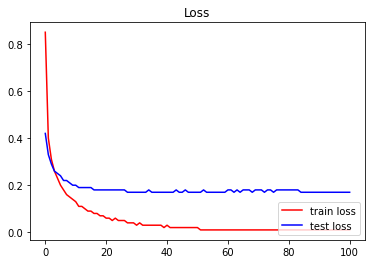

In [62]:
plt.title("Loss")
plt.plot(train_loss_list8, c = 'red', label = 'train loss')
plt.plot(test_loss_list8, c = 'blue', label = 'test loss')
plt.legend(loc = 'lower right')
plt.show()

2. Plot the training and testing accuracies over epochs [2pt]

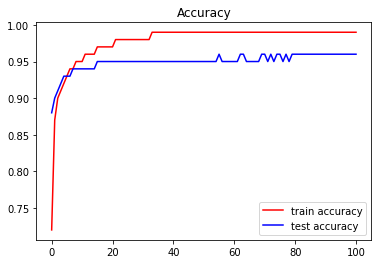

In [63]:
plt.title("Accuracy")
plt.plot(train_acc_list8, c = 'red', label = 'train accuracy')
plt.plot(test_acc_list8, c = 'blue', label = 'test accuracy')
plt.legend(loc = 'lower right')
plt.show()

3. Print the final training and testing losses at convergence [2pt]

In [66]:
data1 = {'' : [train_loss_list8[-1], test_loss_list8[-1]]}
index1 = ['training', 'testing']
frame1 = DataFrame(data1, index = index1)
frame1.columns.name = 'loss'
frame1

loss,
training,0.01
testing,0.17


4. Print the final training and testing accuracies at convergence [20pt]

In [73]:
data2 = {'' : [train_acc_list8[-1], test_acc_list8[-1]]}
index2 = ['training', 'testing']
frame2 = DataFrame(data2, index = index2)
frame2.columns.name = 'accuracy'
frame2

accuracy,
training,0.99
testing,0.96
